In [32]:
#Package calls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

            Week   Sales
Date                    
2021-01-03     0   55429
2021-01-10     1  157706
2021-01-17     2  116824
2021-01-24     3  127530
2021-01-31     4  132029


<Axes: xlabel='Date'>

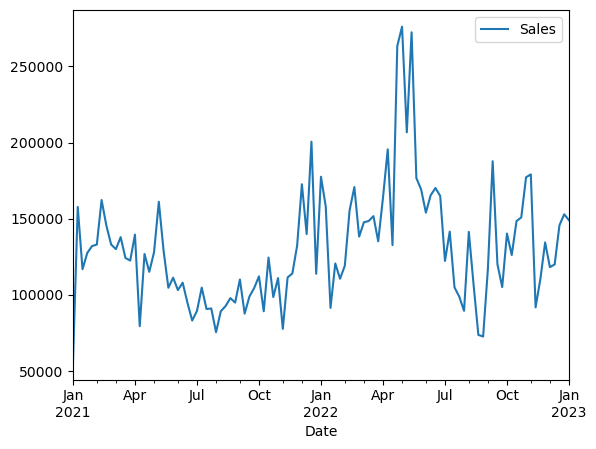

In [34]:
df = pd.read_csv("weekly_sales.csv")

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='raise')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

print(df.head()) 
df = df.drop('Week', axis=1)

df.plot()

In [36]:
# Create a scaler object
scaler = MinMaxScaler()

# Normalize the 'Sales' column
df['Normalized_Sales'] = scaler.fit_transform(df[['Sales']])

# Print the DataFrame with the normalized sales
print(df)

# Save the normalized data to a CSV file as backup
df.to_csv('normalized_sales.csv', index=True)

print(df)

             Sales  Normalized_Sales
Date                                
2021-01-03   55429          0.000000
2021-01-10  157706          0.463539
2021-01-17  116824          0.278254
2021-01-24  127530          0.326775
2021-01-31  132029          0.347166
...            ...               ...
2022-12-04  118205          0.284513
2022-12-11  119977          0.292544
2022-12-18  145669          0.408985
2022-12-25  152917          0.441834
2023-01-01  149007          0.424113

[105 rows x 2 columns]
             Sales  Normalized_Sales
Date                                
2021-01-03   55429          0.000000
2021-01-10  157706          0.463539
2021-01-17  116824          0.278254
2021-01-24  127530          0.326775
2021-01-31  132029          0.347166
...            ...               ...
2022-12-04  118205          0.284513
2022-12-11  119977          0.292544
2022-12-18  145669          0.408985
2022-12-25  152917          0.441834
2023-01-01  149007          0.424113

[105 rows x 2

In [38]:
# Determine the cutoff date for 18 months of data
cutoff_date = df.index.min() + pd.DateOffset(months=18)

# Split the data
train = df[df.index < cutoff_date]
test = df[df.index >= cutoff_date]
total = df[df.index <= cutoff_date]

# Display the split data
print(f"Training data:\n{train.head()}")
print(f"Testing data:\n{test.head()}")


Training data:
             Sales  Normalized_Sales
Date                                
2021-01-03   55429          0.000000
2021-01-10  157706          0.463539
2021-01-17  116824          0.278254
2021-01-24  127530          0.326775
2021-01-31  132029          0.347166
Testing data:
             Sales  Normalized_Sales
Date                                
2022-07-03  122264          0.302909
2022-07-10  141516          0.390162
2022-07-17  104862          0.224040
2022-07-24   98781          0.196479
2022-07-31   89513          0.154475


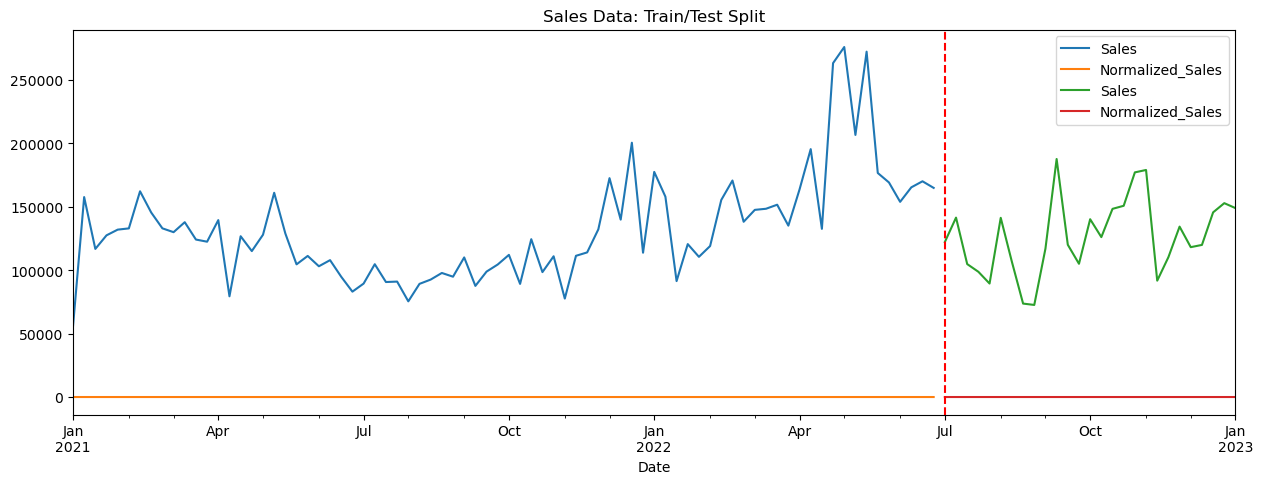

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Test Set")
ax.axvline(cutoff_date, color='red', ls='--')

plt.title("Sales Data: Train/Test Split")
plt.legend()
plt.show()

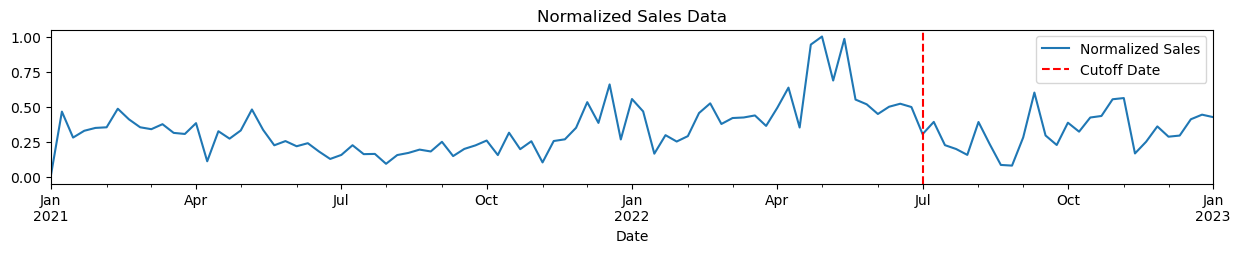

In [42]:
# Assuming 'df' contains a 'Normalized_Sales' column
fig, ax = plt.subplots(figsize=(15, 2))

# Plot the normalized data only
df['Normalized_Sales'].plot(ax=ax, label="Normalized Sales")

# Add a vertical line at the cutoff date
ax.axvline(cutoff_date, color='red', ls='--', label="Cutoff Date")

# Add title and legend
plt.title("Normalized Sales Data")
plt.legend()

# Display the plot
plt.show()

In [44]:
# # Extracting date-related features
# df['Weekday'] = df.index.weekday  # Weekday: 0=Monday, 6=Sunday
# df['Month'] = df.index.month      # Month: 1=January, 12=December
# df['Year'] = df.index.year        # Year
# df['Week'] = df.index.isocalendar().week  # ISO Week number

# # Lag feature: Previous week's sales
# df['Lag_1'] = df['Sales'].shift(1)

# # Drop rows with missing values that result from shifting or date extraction
# df = df.dropna()

# # Features (X) and target (y)
# X = df[['Weekday', 'Month', 'Year', 'Week', 'Lag_1']]  # All the date-related features and the lag
# y = df['Sales']  # The target is sales

In [46]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df = df.copy()
    #df['Weekday'] = df.index.weekday
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week
    df['Lag_1'] = df['Sales'].shift(1)
    df = df.dropna()
    return df

df = create_features(df)

print(df)

             Sales  Normalized_Sales  Month  Year  Week     Lag_1
Date                                                             
2021-01-10  157706          0.463539      1  2021     1   55429.0
2021-01-17  116824          0.278254      1  2021     2  157706.0
2021-01-24  127530          0.326775      1  2021     3  116824.0
2021-01-31  132029          0.347166      1  2021     4  127530.0
2021-02-07  133011          0.351616      2  2021     5  132029.0
...            ...               ...    ...   ...   ...       ...
2022-12-04  118205          0.284513     12  2022    48  134411.0
2022-12-11  119977          0.292544     12  2022    49  118205.0
2022-12-18  145669          0.408985     12  2022    50  119977.0
2022-12-25  152917          0.441834     12  2022    51  145669.0
2023-01-01  149007          0.424113      1  2023    52  152917.0

[104 rows x 6 columns]


In [48]:
# Save the normalized data to a CSV file as backup
df.to_csv('normalized_sales_and_features.csv', index=True)

FEATURES = ['Month', 'Year', 'Week', 'Lag_1']
TARGET = ['Normalized_Sales']

In [50]:
train = create_features(train)
test = create_features(test)

print(train) 
print(test)

             Sales  Normalized_Sales  Month  Year  Week     Lag_1
Date                                                             
2021-01-10  157706          0.463539      1  2021     1   55429.0
2021-01-17  116824          0.278254      1  2021     2  157706.0
2021-01-24  127530          0.326775      1  2021     3  116824.0
2021-01-31  132029          0.347166      1  2021     4  127530.0
2021-02-07  133011          0.351616      2  2021     5  132029.0
...            ...               ...    ...   ...   ...       ...
2022-05-29  169243          0.515826      5  2022    21  176711.0
2022-06-05  153961          0.446566      6  2022    22  169243.0
2022-06-12  165396          0.498391      6  2022    23  153961.0
2022-06-19  170163          0.519996      6  2022    24  165396.0
2022-06-26  164953          0.496383      6  2022    25  170163.0

[77 rows x 6 columns]
             Sales  Normalized_Sales  Month  Year  Week     Lag_1
Date                                                 

In [52]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(X_train.head())
print(y_train.head())

            Month  Year  Week     Lag_1
Date                                   
2021-01-10      1  2021     1   55429.0
2021-01-17      1  2021     2  157706.0
2021-01-24      1  2021     3  116824.0
2021-01-31      1  2021     4  127530.0
2021-02-07      2  2021     5  132029.0
            Normalized_Sales
Date                        
2021-01-10          0.463539
2021-01-17          0.278254
2021-01-24          0.326775
2021-01-31          0.347166
2021-02-07          0.351616


# SVM IMPLEMENTATION

In [107]:
# Ensure target variable is 1D
y_train = y_train.values.ravel()  # Flatten the target array

# Define parameter grid for SVM tuning
param_grid = {
    'C': [0.1, 1, 10, 50, 100],  # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1],  # Epsilon tube for regression
    'kernel': ['linear', 'rbf', 'poly']  # Kernel types
}

# Perform GridSearchCV with corrected training shapes
grid_search = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters found: {'C': 100, 'epsilon': 0.01, 'kernel': 'poly'}


In [109]:
# Train the model using the best hyperparameters found
best_model.fit(X_train, y_train)

SVR(C=100, epsilon=0.01, kernel='poly')

In [111]:
# Make predictions
predSVR = best_model.predict(X_test)

In [113]:
# Predict on the training set
train_predictions = best_model.predict(X_train)

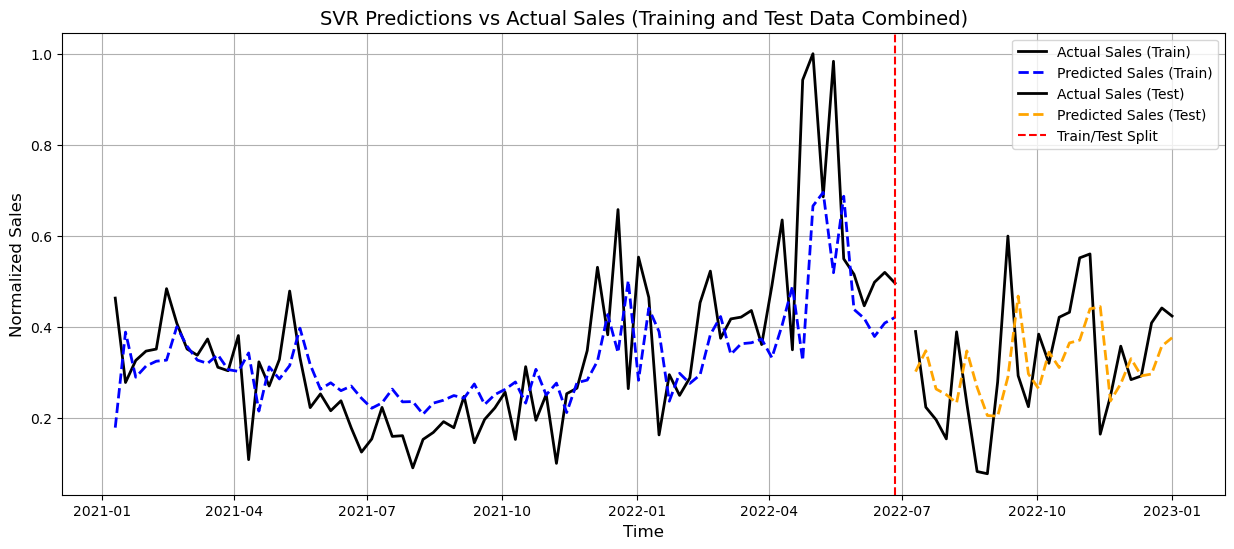

In [115]:
# Plot both Training vs Test predictions together with vertical split
plt.figure(figsize=(15, 6))

# Plot actual sales for the training data
plt.plot(train.index, train['Normalized_Sales'], label="Actual Sales (Train)", color='black', linewidth=2)

# Plot predicted sales for the training set
plt.plot(train.index, train_predictions, linestyle='--', label="Predicted Sales (Train)", color='blue', linewidth=2)

# Plot actual sales for the testing data
plt.plot(test.index, test['Normalized_Sales'], label="Actual Sales (Test)", color='black', linewidth=2)

# Plot predicted sales for the testing set
plt.plot(test.index, predSVR, linestyle='--', label="Predicted Sales (Test)", color='orange', linewidth=2)

# Separate training and testing data with a vertical line
cutoff_date = train.index[-1]  # Mark the split point using the last date from the training set
plt.axvline(cutoff_date, color='red', linestyle='--', label='Train/Test Split')

# Add labels, legend, and grid
plt.xlabel("Time", fontsize=12)
plt.ylabel("Normalized Sales", fontsize=12)
plt.title("SVR Predictions vs Actual Sales (Training and Test Data Combined)", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [117]:
#Evaluation Metric
rmse_SVR = root_mean_squared_error(y_test, predSVR)
mape_SVR = mean_absolute_percentage_error (y_test, predSVR)
r2_SVR = r2_score(y_test, predSVR)

print(f'The Root Mean Square Error (RMSE) is {rmse_SVR}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_SVR}')
print(f'R-Squared (R²) is {r2_SVR}')

The Root Mean Square Error (RMSE) is 0.13164801163671472
Mean Absolute Percentage Error (MAPE) is 0.47245349706986584
R-Squared (R²) is 0.05760935560096514


# LINEAR REGRESSION IMPLEMENTATION

In [54]:
linearReg = LinearRegression()

In [56]:
linearReg.fit(X_train, y_train)

LinearRegression()

Feature: 0, Score: -0.01044
Feature: 1, Score: 0.12283
Feature: 2, Score: 0.00235
Feature: 3, Score: 0.00000


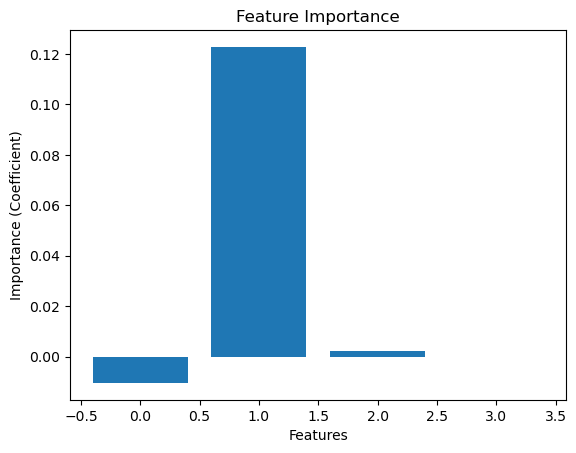

In [58]:
# Extract coefficients from the model
importance = linearReg.coef_.ravel()  # Flatten the array to 1D if necessary

# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

# Plot feature importance
import matplotlib.pyplot as plt  # Ensure matplotlib is imported

plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Importance (Coefficient)')
plt.title('Feature Importance')
plt.show()


In [60]:
test['Predictions_LR'] = linearReg.predict(X_test)
train['Predictions_LR'] = linearReg.predict(X_train)

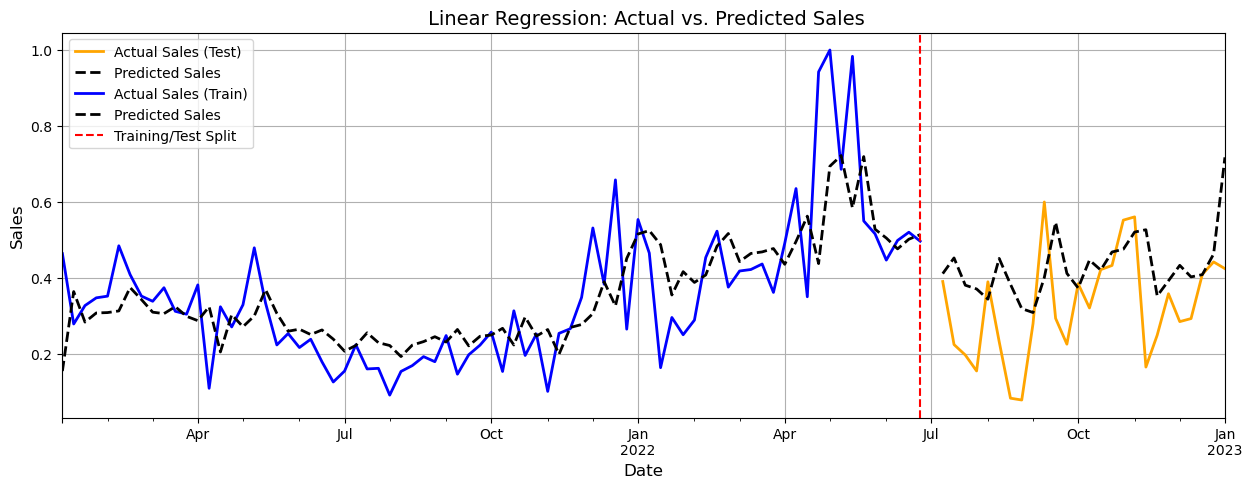

In [62]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_LR'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Plot predicted sales (test data)
train['Predictions_LR'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title(" Linear Regression: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [66]:
#Evaluation Metric
rmse_LR = root_mean_squared_error(y_test, test['Predictions_LR'])
mape_LR = mean_absolute_percentage_error (y_test, test['Predictions_LR'])
r2_LR = r2_score(y_test, test['Predictions_LR'])

print(f'The Root Mean Square Error (RMSE) is {rmse_LR}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_LR}')
print(f'R-Squared (R²) is {r2_LR}')

The Root Mean Square Error (RMSE) is 0.17078350172148568
Mean Absolute Percentage Error (MAPE) is 0.706568461123169
R-Squared (R²) is -0.5859671439578824


# Random Forest Implementations

In [69]:
# randomForestModel = RandomForestRegressor(n_estimators=1000, max_features=4, random_state=1)

In [71]:
# randomForestModel.fit(X_train, y_train)

C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=4, n_estimators=1000, random_state=1)

In [119]:
# Function to train Random Forest with hyperparameter tuning using GridSearchCV
def train_random_forest_grid(X_train, y_train):
    # Create the Random Forest Regressor
    randomForestModel = RandomForestRegressor(random_state=1)

    # Define the hyperparameter grid
    param_grid = {
        "n_estimators": [500, 1000, 1500],  # Number of trees in the forest
        "max_depth": [None, 10, 20, 30],
        "max_features": [2, 4, 6, 'auto'],  # Number of features to consider at each split
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    # Initialize GridSearchCV for hyperparameter optimization
    grid_search = GridSearchCV(
        estimator=randomForestModel,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,  # Use all available cores
        scoring='neg_mean_squared_error'  # Using MSE as a scoring metric
    )

    # Fit the model with the provided training data
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print("Best Hyperparameters found:")
    print(grid_search.best_params_)

    # Return the best model
    best_model = grid_search.best_estimator_
    return best_model

In [121]:
# Train the model using GridSearchCV
randomForestModel = train_random_forest_grid(X_train, y_train)

C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
524 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ACER\anaconda3\Lib\site-packages\s

Best Hyperparameters found:
{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


Feature: 0, Score: 0.13328
Feature: 1, Score: 0.21362
Feature: 2, Score: 0.22910
Feature: 3, Score: 0.42400


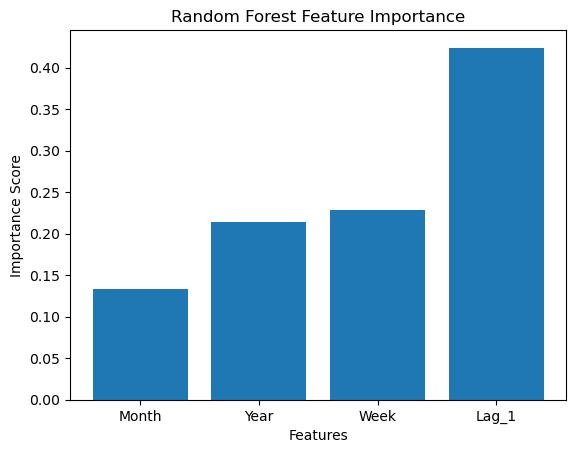

In [123]:
# Get feature importance
importance = randomForestModel.feature_importances_

# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance, tick_label=FEATURES)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.show()

In [125]:
predRF1 = randomForestModel.predict(X_test)
test["Predictions_RF"] = predRF1

predRF2 = randomForestModel.predict(X_train)
train["Predictions_RF"] = predRF2


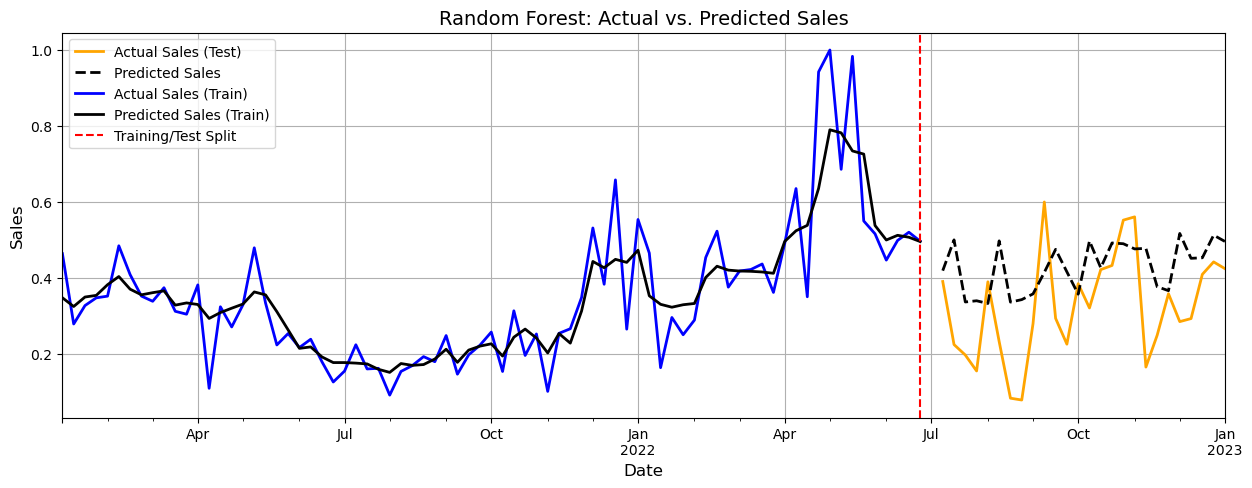

In [127]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_RF'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Plot actual sales (training data)
train['Predictions_RF'].plot(ax=ax, label="Predicted Sales (Train)", color='black', linewidth=2)


# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("Random Forest: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [129]:
#Evaluation Metric
rmse_RF = root_mean_squared_error(y_test, predRF1)
mape_RF = mean_absolute_percentage_error (y_test, predRF1)
r2_RF = r2_score(y_test, predRF1)

print(f'The Root Mean Square Error (RMSE) is {rmse_RF}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_RF}')
print(f'R-Squared (R²) is {r2_RF}')

The Root Mean Square Error (RMSE) is 0.16407116869477043
Mean Absolute Percentage Error (MAPE) is 0.7027560218381563
R-Squared (R²) is -0.4637499765314521


In [83]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 812.7 kB/s eta 0:02:34
   ---------------------------------------- 0.2/124.9 MB 1.5 MB/s eta 0:01:24
   ---------------------------------------- 0.4/124.9 MB 2.7 MB/s eta 0:00:46
   ---------------------------------------- 1.1/124.9 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 2.0/124.9 MB 7.8 MB/s eta 0:00:16
    --------------------------------------- 2.8/124.9 MB 9.4 MB/s eta 0:00:14
   - -------------------------------------- 3.7/124.9 MB 10.8 MB/s eta 0:00:12
   - -------------------------------------- 4.4/124.9 MB 11.1 MB/s eta 0:00:11
   - -------------------------------------- 5.0/124.9 MB 11.4 MB/s eta 0:00:11
   - -------------------------------------- 5.7/124.9 MB 11.8 MB/s eta 0:00:11
   -- ------------------------------------- 6.6/124.9 MB 12.4 MB/s eta 0

In [85]:
import xgboost as xg
from xgboost import XGBRegressor

In [87]:
# Define the model
xgboost_model = XGBRegressor()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [89]:
# Example of using best parameters from GridSearchCV or RandomizedSearchCV
best_params = grid_search.best_params_  # Replace with your tuning method's result

# Initialize the model with the best parameters
final_model = XGBRegressor(**best_params)

# Train the model on the full training dataset
final_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [91]:
# Predict on training data
train['Predictions_XGB'] = final_model.predict(X_train)

# Predict on test data
test['Predictions_XGB'] = final_model.predict(X_test)

# Ensure `y_pred` is defined
y_pred = test['Predictions_XGB']  # Use predictions from the test set

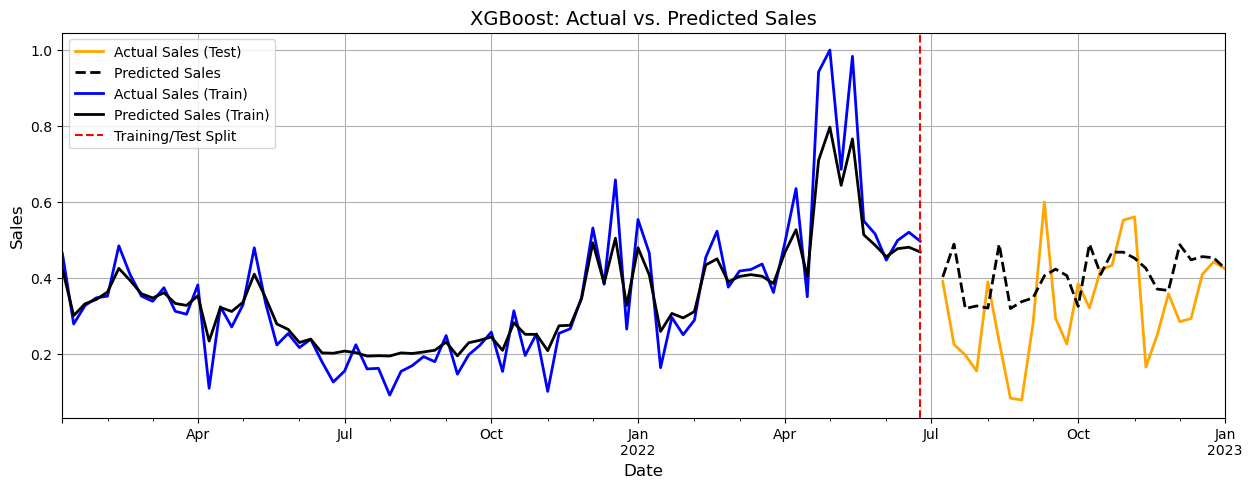

In [93]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_XGB'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Normalized_Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Plot actual sales (training data)
train['Predictions_XGB'].plot(ax=ax, label="Predicted Sales (Train)", color='black', linewidth=2)


# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("XGBoost: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [105]:
rmse = mean_squared_error(y_test, test['Predictions_XGB'])  # Ensure squared=False for RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAPE
mape = mean_absolute_percentage_error(y_test, test['Predictions_XGB'])  # MAPE calculation
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

#rsquared
r2 = r2_score(y_test, test['Predictions_XGB'])
print(f'R-Squared (R²) is {r2}')

Root Mean Squared Error (RMSE): 0.023162313967583687
Mean Absolute Percentage Error (MAPE): 0.6473308622000455
R-Squared (R²) is -0.25945977690937005
